In [2]:
set.seed(123)
getwd()
setwd("/liulab/galib/dlbcl_manuscript/")
library(rBCS)
library(tidyverse)
library(Seurat)
library(harmony)
library(viridis)
library(RColorBrewer)
library(Polychrome)
PurpleAndYellow()
library(ComplexHeatmap)
library(devtools)
library(presto)
library(dplyr)
library(ggplot2)
library(ggpubr)
library(readxl)
library(CytoTRACE2)
source("./scripts/scplot.R")

[1] "/liulab/galib/dlbcl_manuscript/scripts"

Warning message:
“package ‘rBCS’ was built under R version 4.1.3”
Warning message:
“package ‘tidyverse’ was built under R version 4.1.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.1 
✔ purrr   0.3.4      

Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
Warning message:
“package ‘forcats’ was built under R version 4.1.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ tidyr::expand()     masks Matrix::expand()
✖ tidyr::fill()       masks VGAM::fill()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ tidyr::pack()       masks Matrix::pack()
✖ ggplot2::Position() masks BiocGenerics::Position(), base::Position()
✖ t

[1] "#FF00FF" "#F400F4" "#EA00EA" "#DF00DF" "#D500D5" "#CA00CA" "#BF00BF"
 [8] "#B500B5" "#AA00AA" "#9F009F" "#950095" "#8A008A" "#800080" "#750075"
[15] "#6A006A" "#600060" "#550055" "#4A004A" "#400040" "#350035" "#2B002B"
[22] "#200020" "#150015" "#0B000B" "#000000" "#000000" "#0B0B00" "#151500"
[29] "#202000" "#2B2B00" "#353500" "#404000" "#4A4A00" "#555500" "#606000"
[36] "#6A6A00" "#757500" "#808000" "#8A8A00" "#959500" "#9F9F00" "#AAAA00"
[43] "#B5B500" "#BFBF00" "#CACA00" "#D4D400" "#DFDF00" "#EAEA00" "#F4F400"
[50] "#FFFF00"

Warning message:
“package ‘ComplexHeatmap’ was built under R version 4.1.3”
Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Loading required package: usethis

Warning message:
“package ‘presto’ was built under R version 4.1.3”
Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The

In [34]:
library(monocle3)
library(SeuratWrappers)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
“package ‘matrixStats’ was built under R version 4.1.3”

Attaching package: ‘matrixStats’


The following object is masked from ‘package:plyr’:

    count


The following object is masked from ‘package:dplyr’:

    count


The following objects are masked from ‘package:Biobase’:

    anyMissing, rowMedians



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads

In [3]:
B_cell<- readRDS("./data/objects/B_cell_final.rds")
B_cell_trust4<- read_tsv(file = "./data/B_cell_metadata_trust4_results.tsv", col_names = TRUE)
B_cell_trust4  %>% filter(sample_id %in% c('191', '004', '109', '90b'))  %>% 
    filter(!is.na(cdr3aa))   %>%  select(sample_id, cdr3aa)  %>% count(vars = c('sample_id', 'cdr3aa'))  %>% 
    arrange(sample_id, -freq)  %>% 
    group_by(sample_id) %>% top_n(n = 1)


expanded_cdr3aa<- B_cell_trust4  %>% filter(sample_id %in% c('191', '004', '109', '90b'))  %>% 
    filter(!is.na(cdr3aa))   %>%  select(sample_id, cdr3aa)  %>% count(vars = c('sample_id', 'cdr3aa'))  %>% 
    arrange(sample_id, -freq)  %>% 
    group_by(sample_id) %>% top_n(n = 1)  %>% pull(cdr3aa)

expanded_cells<- B_cell_trust4  %>% 
    filter(sample_id %in% c('191', '004', '109', '90b'))  %>%
    filter(!is.na(cdr3aa))  %>% 
    filter(cdr3aa %in% expanded_cdr3aa)  %>% 
    pull(barcode)

Rows: 176583 Columns: 42
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (24): orig.ident, sample_id, age, genotype, gender, type, clonality, flo...
dbl (18): nCount_RNA, nFeature_RNA, frozen_cells_x106, spl_g, percent.mt, RN...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Selecting by freq


sample_id,cdr3aa,freq
<chr>,<chr>,<int>
004,CARIAWRYYGTDFDYW,498
109,CARTLYYGSTPGYFDVW,57
191,CANYGSSYWYFDVW,326
90b,CARTPYGSSFDYW,545


Selecting by freq


In [4]:
B_cell_list = list()
for (sample in c('191', '004', '109', '90b')){
    B_cell_subset = subset(B_cell, sample_id == sample & (Cells(B_cell) %in% expanded_cells))
    message('number of cells in ', sample, ' is: ', dim(B_cell_subset)[2])
    B_cell_list<- c(B_cell_list, B_cell_subset)
}

number of cells in 191 is: 326

number of cells in 004 is: 498

number of cells in 109 is: 57

number of cells in 90b is: 545



### mouse 191

In [253]:
for ( i in c(3:length(B_cell_list))){
    
    sampleID<- c('191', '004', '109', '90b')[i]
    
    message('processing ', sampleID)
    
    obj<- B_cell_list[[i]]
    DimPlot(obj, group.by = 'new_annotation')
    ggsave(paste0('./results/figures/9_', sampleID, '_DimPlot.pdf'), width = 12, height = 6)
    
    message('converting to cds... ')
    cds <- as.cell_data_set(obj)
    
    message('clustering... ')
    cds <- cluster_cells(cds, resolution = 0.6)
    
    message('learning graphs...')
    cds <- learn_graph(cds)
    
    message('plotting tree...')
    plot_cells(cds, label_leaves = TRUE, label_branch_points = TRUE, cell_size = 1.2)
    ggsave(paste0('./results/figures/9_monocle3_tree_', sampleID, '.pdf'), width = 8, height = 6)

    message('ranking cells')
    root = obj@meta.data  %>% filter(new_annotation== '5_Atypical Marginal Zone')  %>% rownames()
    cds <- order_cells(cds, root_cells = root)


    message('plotting pseudotime')
    plot_cells(cds, color_cells_by = "pseudotime", label_cell_groups = FALSE, label_leaves = FALSE, 
        label_branch_points = FALSE, cell_size = 1.2)
    ggsave(paste0('./results/figures/9_monocle3_pseudotime_', sampleID, '.pdf'), width = 8, height = 6)

    
    message('plotting pseudotime on featureplot')
    
    obj@meta.data$pseudotime = pseudotime(cds)[rownames(obj@meta.data)]
    obj@meta.data[names(pseudotime(cds)[is.infinite(pseudotime(cds))]), 'pseudotime'] = NA

    p<- FeaturePlot(obj, "pseudotime")
    ggsave(filename = paste0('./results/figures/9_monocle3_pseudotime_', sampleID, '_featureplot.pdf'), plot = p, width = 8, height = 6)
    
}

processing 109

converting to cds... 

clustering... 

learning graphs...

Warning message in cluster_cells_make_graph(data = data, weight = weight, cell_names = cell_names, :
“The nearest neighbors includes the point itself, k must be smaller than
the total number of points - 1 (all other points) - 1 (itself)! Total number of points is 21”
Warning message in igraph::graph.dfs(stree_ori, root = root_cell, neimode = "all", :
“Argument `neimode' is deprecated; use `mode' instead”
Warning message in igraph::graph.dfs(stree_ori, root = root_cell, neimode = "all", :
“Argument `neimode' is deprecated; use `mode' instead”
plotting tree...

ranking cells

plotting pseudotime

plotting pseudotime on featureplot

processing 90b

converting to cds... 

clustering... 

learning graphs...

Warning message in igraph::graph.dfs(stree_ori, root = root_cell, neimode = "all", :
“Argument `neimode' is deprecated; use `mode' instead”
plotting tree...

ranking cells

plotting pseudotime

plotting pseudotim

processing 004

converting to cds... 

clustering... 

learning graphs...

Warning message in igraph::graph.dfs(stree_ori, root = root_cell, neimode = "all", :
“Argument `neimode' is deprecated; use `mode' instead”
Warning message in igraph::graph.dfs(stree_ori, root = root_cell, neimode = "all", :
“Argument `neimode' is deprecated; use `mode' instead”
plotting tree...



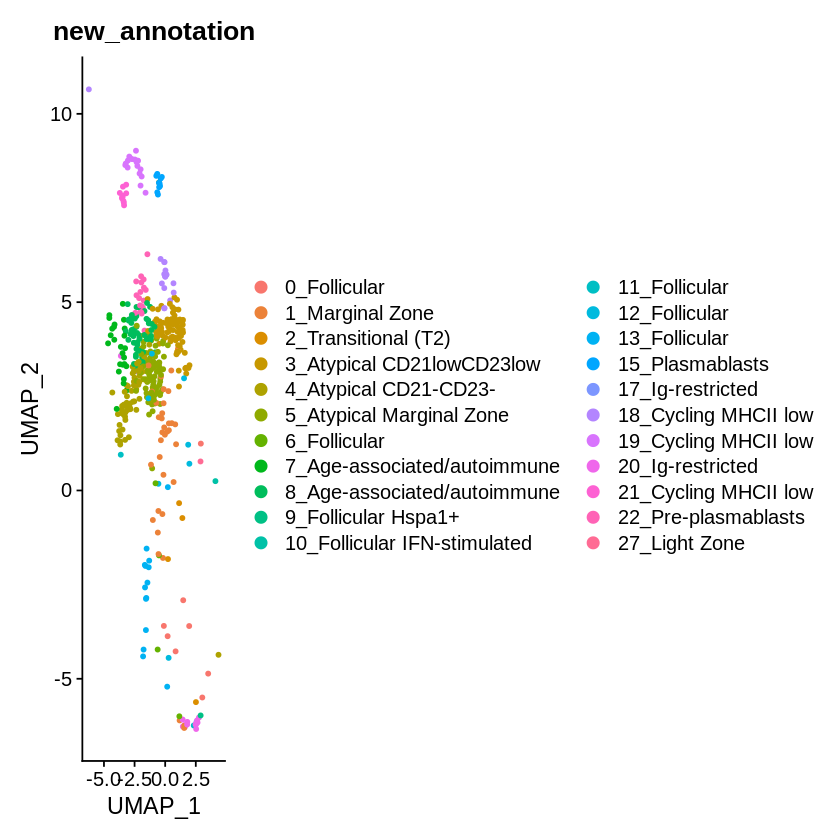

ranking cells

plotting pseudotime



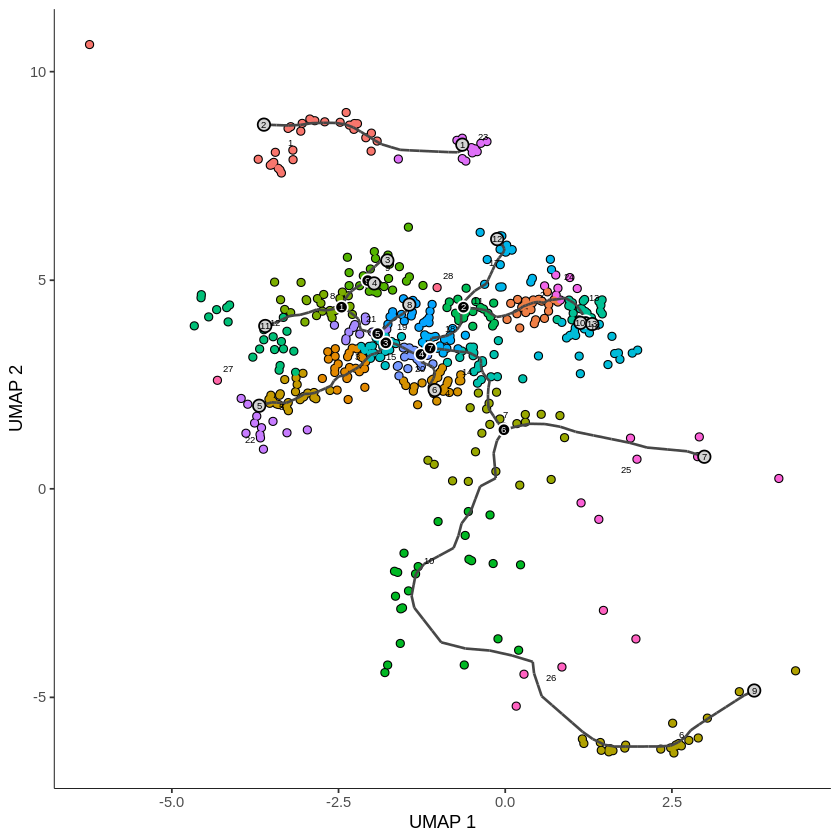

plotting pseudotime on featureplot



ERROR: Error in seq.default(.limits[1], .limits[2], length.out = guide$nbin): 'to' must be a finite number


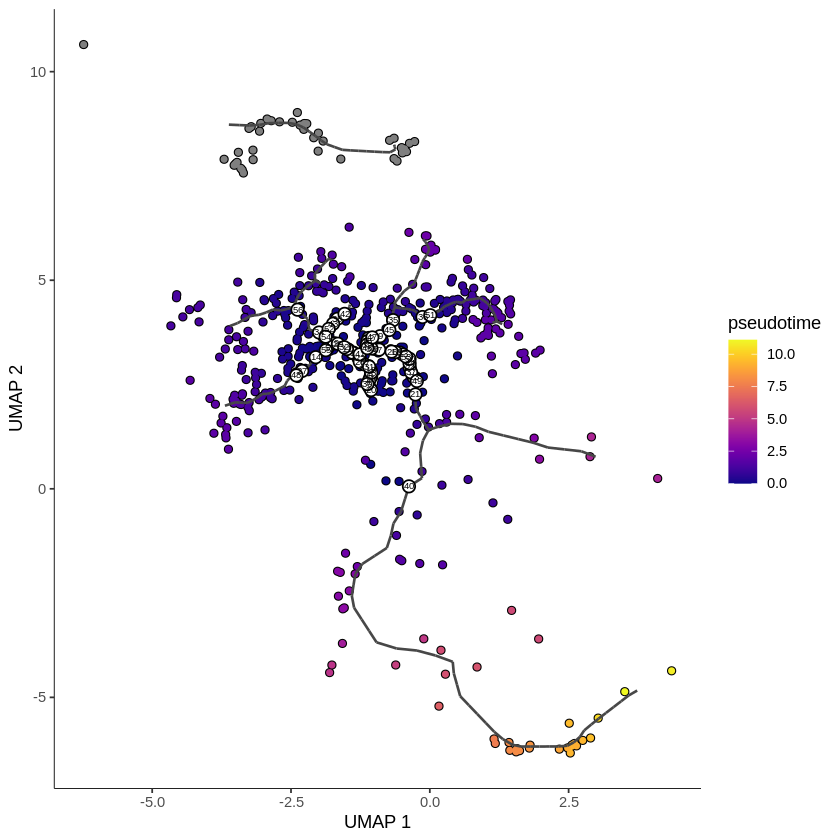

In [238]:
i=2
sampleID<- c('191', '004', '109', '90b')[i]

message('processing ', sampleID)

obj<- B_cell_list[[i]]
DimPlot(obj, group.by = 'new_annotation')
ggsave(paste0('./results/figures/9_', sampleID, '_DimPlot.pdf'), width = 12, height = 6)

message('converting to cds... ')
cds <- as.cell_data_set(obj)

message('clustering... ')
cds <- cluster_cells(cds, resolution = 0.6)

message('learning graphs...')
cds <- learn_graph(cds)

message('plotting tree...')
plot_cells(cds, label_leaves = TRUE, label_branch_points = TRUE, cell_size = 1.2)
ggsave(paste0('./results/figures/9_monocle3_tree_', sampleID, '.pdf'), width = 8, height = 6)

message('ranking cells')
root = obj@meta.data  %>% filter(new_annotation== '5_Atypical Marginal Zone')  %>% rownames()
cds <- order_cells(cds, root_cells = root)


message('plotting pseudotime')
plot_cells(cds, color_cells_by = "pseudotime", label_cell_groups = FALSE, label_leaves = FALSE, 
    label_branch_points = FALSE, cell_size = 1.2)
ggsave(paste0('./results/figures/9_monocle3_pseudotime_', sampleID, '.pdf'), width = 8, height = 6)


message('plotting pseudotime on featureplot')

obj@meta.data$pseudotime = pseudotime(cds)[rownames(obj@meta.data)]
obj@meta.data[names(pseudotime(cds)[is.infinite(pseudotime(cds))]), 'pseudotime'] = NA

p<- FeaturePlot(obj, "pseudotime")
ggsave(filename = paste0('./results/figures/9_monocle3_pseudotime_', sampleID, '_featureplot.pdf'), plot = p, width = 8, height = 6)


In [241]:
FeaturePlot(obj, "pseudotime")

ERROR while rich displaying an object: Error in seq.default(.limits[1], .limits[2], length.out = guide$nbin): 'to' must be a finite number

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_t

In [63]:
#Extract count data, phenotype data, and feature data from the Seurat Object.
counts.data <- as(as.matrix(Seurat.object@assays$RNA@data), 'sparseMatrix')
pheno.data <- Seurat.object@meta.data
feature.data <- data.frame(gene_short_name = row.names(counts.data), row.names = row.names(counts.data))

#Construct a CellDataSet.
cds <- new_cell_data_set(counts.data, cell_metadata = pheno.data, gene_metadata = feature.data)

In [98]:
?reduce_dimension

In [73]:
cds <- preprocess_cds(cds, num_dim = 50)
plot_pc_variance_explained(cds)
cds <- reduce_dimension(cds, preprocess_method = 'PCA')
plot_cells(cds, reduction_method = 'UMAP', label_groups_by_cluster=FALSE,
           color_cells_by = "new_annotation", cell_size = 1.8, group_label_size=5)

In [148]:
?cluster_cells

In [138]:
cds <- cluster_cells(cds, k=10)
cds <- learn_graph(cds)

  |======================================================================| 100%


Warning message in igraph::graph.dfs(stree_ori, root = root_cell, neimode = "all", :
“Argument `neimode' is deprecated; use `mode' instead”
